In [29]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import plotly.express as px


In [30]:
data=pd.read_csv("sales_data_sample.csv",encoding='unicode_escape')
print(data.info())
print(data.head())
print(data.describe())
print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ORDERNUMBER       2823 non-null   int64  
 1   QUANTITYORDERED   2823 non-null   int64  
 2   PRICEEACH         2823 non-null   float64
 3   ORDERLINENUMBER   2823 non-null   int64  
 4   SALES             2823 non-null   float64
 5   ORDERDATE         2823 non-null   object 
 6   STATUS            2823 non-null   object 
 7   QTR_ID            2823 non-null   int64  
 8   MONTH_ID          2823 non-null   int64  
 9   YEAR_ID           2823 non-null   int64  
 10  PRODUCTLINE       2823 non-null   object 
 11  MSRP              2823 non-null   int64  
 12  PRODUCTCODE       2823 non-null   object 
 13  CUSTOMERNAME      2823 non-null   object 
 14  PHONE             2823 non-null   object 
 15  ADDRESSLINE1      2823 non-null   object 
 16  ADDRESSLINE2      302 non-null    object 


Tomar del dataset los campos necesarios para obtener los valores de Recency, Frequency y Monetary Value además de una forma de identificacion del cliente
CUSTOMERNAME: identificación del cliente
ORDERNUMBER: identificación de la orden
ORDERDATE: fecha de la orden
SALES: importe de esa orden

In [31]:
temp=['CUSTOMERNAME', 'ORDERNUMBER', 'ORDERDATE', 'SALES']
RFM_data=data[temp]
RFM_data.shape

(2823, 4)

In [32]:
#NOW: establecida como fecha actual teniendo en cuenta que la última fecha en el dataset es del 31 de mayo de 2005
NOW = dt.datetime(2005,6,1)
#Convertir la columna ORERDATE en formato de fecha y hora.
RFM_data['ORDERDATE'] = pd.to_datetime(RFM_data['ORDERDATE'])
# Tabla RFM agrupando los datos por clientes
# obteniendo Recency a partir de las fechas de las ordenes 
# Frequency a partir de las identificación de órdenes 
# Monetary a partir de los importes de cada orden
RFM_table=RFM_data.groupby('CUSTOMERNAME').agg({'ORDERDATE': lambda x: (NOW - x.max()).days, # Recency
                                                'ORDERNUMBER': lambda x: len(x.unique()), # Frequency
                                                'SALES': lambda x: x.sum()})    # Monetary 
#Convertir a enteros la columna ORDERDATE que ahora contine el tiempo en días transcurrido desde la  última compra
RFM_table['ORDERDATE'] = RFM_table['ORDERDATE'].astype(int)

RFM_table.rename(columns={'ORDERDATE': 'recency', 
                         'ORDERNUMBER': 'frequency',
                         'SALES': 'monetary_value'}, inplace=True)

RFM_table.head()

C:\Users\Rey\AppData\Local\Temp\ipykernel_6700\3647109275.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,recency,frequency,monetary_value
CUSTOMERNAME,,,
"AV Stores, Co.",196,3,157807.81
Alpha Cognac,65,3,70488.44
Amica Models & Co.,265,2,94117.26
"Anna's Decorations, Ltd",84,4,153996.13
Atelier graphique,188,3,24179.96


In [33]:
data = RFM_table[["recency","frequency","monetary_value"]]
#usar np.log para normalizar los valores
df_log = np.log(data)

In [34]:
#usar StandardScaler para tener todos los valores en la misma escala
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
df_scaled = std_scaler.fit_transform(df_log)

Usar The Elbow Method para determinar el número de clusters necesarios para el modelo KMeans

In [35]:
#usar un modelo KMeans para el clustering
from sklearn.cluster import KMeans
errors = []
for k in range(1, 11):
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(df_scaled)
    errors.append(model.inertia_)

C:\Users\Rey\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Rey\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Rey\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Rey\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



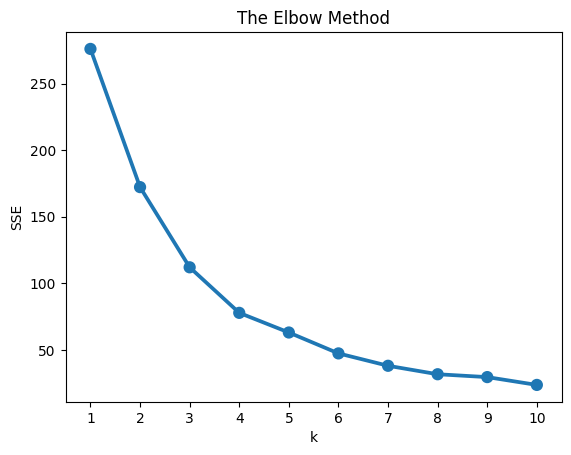

In [36]:
plt.title('The Elbow Method')
plt.xlabel('k'); plt.ylabel('SSE')
sns.pointplot(x=list(range(1, 11)), y=errors)
plt.savefig("Elbow.png")

In [37]:
from kneed import KneeLocator
kl = KneeLocator(x = range(1, 11),
                 y = errors,
                 curve="convex",
                 direction="decreasing")
print('El número optimo de clústers es: ' + str(kl.elbow))

El número optimo de clústers es: 4


In [38]:
model = KMeans(n_clusters=4, random_state=42)
model.fit(df_scaled)

C:\Users\Rey\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



KMeans(n_clusters=4, random_state=42)

In [39]:
#asignar las etiquetas obtenidas del modelo al dataframe
data = data.assign(ClusterLabel= model.labels_)

Obteniendo una media de cada columna correspondiente a cada clúster que permita interpretar los datos agrupados en cada uno

In [40]:
data.groupby("ClusterLabel")[["recency","frequency","monetary_value"]].median()

,recency,frequency,monetary_value
ClusterLabel,,,
0,136.0,3.0,104466.170
1,2.0,21.5,783576.085
2,259.0,2.0,64834.320
3,2.0,4.0,149798.630


Cluster 0: clientes con baja frecuencia de compras que hace tiempo que no compran (clientes probablemente al borde de provocar churn)
Cluster 1: clientes con alta frecuencia de compras que compraron hace poco (clientes muy buenos)
Cluster 2: clientes con baja frecuencia de compras que hace mucho tiempo que no compran (clientes probablemente perdidos)
Cluster 3: clientes con baja frecuencia de compras que compraron hace poco (clientes nuevos)

In [41]:
fig = px.scatter_3d(
    data_frame=data,
    x = "recency",
    y= "monetary_value",
    z="frequency",
    title = "Visualizacion de los 4 clusters",
    color = "ClusterLabel",
    height=500
)
fig.show()